# Exploring GTSAM  Package for Pose Optimization with Factor Graphs

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

# import gtsampy as gtsam
import gtsam
import gtsam.utils.plot as gtsam_plot
import matplotlib.pyplot as plt
import numpy as np
from ipyvtklink.viewer import ViewInteractiveWidget
from vedo import  *

Autosaving every 180 seconds


In [18]:
import tensorflow as tf
from tensorflow import  sin, cos, tan

def R_tf(angs):
    """generates rotation matrix using euler angles
    angs = tf.constant(phi, theta, psi) (aka rot about (x,y,z))
            can be single set of angles or batch for multiple cells
    """

    if len(tf.shape(angs)) == 1:
        angs = angs[None,:]
    phi = angs[:,0]
    theta = angs[:,1]
    psi = angs[:,2]

    mat = tf.Variable([[cos(theta)*cos(psi), sin(psi)*cos(phi) + sin(phi)*sin(theta)*cos(psi), sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi)],
                       [-sin(psi)*cos(theta), cos(phi)*cos(psi) - sin(phi)*sin(theta)*sin(psi), sin(phi)*cos(psi) + sin(theta)*sin(psi)*cos(phi)],
                       [sin(theta), -sin(phi)*cos(theta), cos(phi)*cos(theta)]
                        ])

    mat = tf.transpose(mat, [2, 0, 1])
    mat = tf.squeeze(mat)
    return mat

# Establish Origin 

$ [x, y, z, \phi, \theta, \psi ] $

In [19]:
p = np.array([0,0,0,0,0,0], dtype = np.float64)
start = gtsam.Pose3(p)
print(start)

# newpt = gtsam.Pose3(np.array([1,1,1,0,0,0], dtype = np.float64))

R: [
	0, 3.16202e-322, 6.93007e-310;
	0, 2.37646e-321, 6.93007e-310;
	0, 2.25411e-315, 6.93023e-310
]
t: 6.93007e-310 6.93007e-310 6.93007e-310



# 3D Odometry with PixSet

In [310]:
#leddartech braided odometry via ICET ROS pkg ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# nframes = 100
# odometry_history = np.load("test_data/leddartech_pixset/T_vec_history.npy")[:nframes,:]
# pred_stds_history = np.load("test_data/leddartech_pixset/cov_vec_history.npy")[:nframes,:]
# #debug- only use non-releated indices
# # good_idx = np.array([0,1,3]) #,5,7])
# # odometry_history = odometry_history[good_idx]
# # print(odometry_history.dtype)
# ij = get_ij(odometry_history[:,6:].astype(np.int32)).numpy() #indices of each

#simplified data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# odometry_history = np.array([[1., 0, 0, 0, 0, 0.0, 1, 2],
#                              [2., 1, 0, 0, 0, 0., 2, 3],
# #                              [2., 2, 0, 0, 0, 0., 2, 3], #conflicting measurement for frames 1 -> 2
#                              [3., 1, 1, 0, 0, 0., 3, 4]])

npts = 100
odometry_history = np.tile(np.array([0.0, 0.05, 0.02, 0.0, 0.0, 0.1]), (npts,1))
pred_stds_history = np.tile(np.array([[0.01, 0.01, 0.01, 1e-4, 1e-4, 1e-4]]), (len(odometry_history),1))
ij = np.array([[0,1]])
for i in range(1,len(odometry_history)):
    ij = np.append(ij, np.array([[i, i+1]]), axis = 0)
odometry_history = np.append(odometry_history, ij, axis= 1)   #match format output by ROS package
pred_stds_history = np.append(pred_stds_history, ij, axis= 1) #match format output by ROS package
# print(odometry_history)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# print(ij)

[[  0.     0.05   0.02   0.     0.     0.1    0.     1.  ]
 [  0.     0.05   0.02   0.     0.     0.1    1.     2.  ]
 [  0.     0.05   0.02   0.     0.     0.1    2.     3.  ]
 [  0.     0.05   0.02   0.     0.     0.1    3.     4.  ]
 [  0.     0.05   0.02   0.     0.     0.1    4.     5.  ]
 [  0.     0.05   0.02   0.     0.     0.1    5.     6.  ]
 [  0.     0.05   0.02   0.     0.     0.1    6.     7.  ]
 [  0.     0.05   0.02   0.     0.     0.1    7.     8.  ]
 [  0.     0.05   0.02   0.     0.     0.1    8.     9.  ]
 [  0.     0.05   0.02   0.     0.     0.1    9.    10.  ]
 [  0.     0.05   0.02   0.     0.     0.1   10.    11.  ]
 [  0.     0.05   0.02   0.     0.     0.1   11.    12.  ]
 [  0.     0.05   0.02   0.     0.     0.1   12.    13.  ]
 [  0.     0.05   0.02   0.     0.     0.1   13.    14.  ]
 [  0.     0.05   0.02   0.     0.     0.1   14.    15.  ]
 [  0.     0.05   0.02   0.     0.     0.1   15.    16.  ]
 [  0.     0.05   0.02   0.     0.     0.1   16.    17. 

In [312]:
#load LeddarTech dataset
from utils import get_ij

# Create an empty nonlinear factor graph
graph = gtsam.NonlinearFactorGraph() 

# Add a prior on the first pose, setting it to the origin
# A prior factor consists of a mean and a noise model (covariance matrix)
priorMean = gtsam.Pose3(np.zeros([6,1], dtype = np.float64))  # prior at origin
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(
    np.array([0.1, 0.1, 0.1, 0.001, 0.001, 0.001], dtype = np.float64))
# firstKey = initial.keys()[0] #TODO: what does this do???
graph.add(gtsam.PriorFactorPose3(0, priorMean, PRIOR_NOISE)) #constrain first point at priorMean

#loop through all constraints 
# for i in range(len(ij)):
for i in range(int(np.max(ij))):
    #get constraint 
    raw_odom = odometry_history[i,:-2] #omit scan indices stored at end of line
#     raw_odom = odometry_history[i,:]
#     print("\n raw_odom: \n", raw_odom)    

    #convert to Point3 strucutre
    point = raw_odom[:3] 
    rot = gtsam.Rot3(R_tf(raw_odom[3:]))
    odometry_estimate = gtsam.Pose3(rot, point)
#     print("\n odometry estimate:\n", odometry_estimate)

    cov_estimate = gtsam.noiseModel.Diagonal.Sigmas(pred_stds_history[i,:-2])
#     cov_estimate = gtsam.noiseModel.Diagonal.Sigmas(pred_stds_history[i,:]) #dont need to omit scan indices for fake data
    first_idx = ij[i,0]
    second_idx = ij[i,1] 
    graph.add(gtsam.BetweenFactorPose3(first_idx, second_idx, odometry_estimate, cov_estimate))

# print(graph.size())
#set to zero initial conditions
initial = gtsam.Values()
# print(graph.size())
# print(int(np.max(ij)))
for j in range(graph.size()):
# for j in range(int(np.max(ij))):
#     zero_rot = gtsam.Rot3(R_tf(np.array([0., 0., 0.])))
#     zero_pose3 = gtsam.Pose3(zero_rot, np.array([0., 0., 0.])) #does not work with zero initial conds??
    init_rot = gtsam.Rot3(R_tf(0.01*np.random.randn(3)))
    init_pose = gtsam.Pose3(init_rot, np.random.randn(3))
    initial.insert(j, zero_pose3)
    
    
# optimize using Levenberg-Marquardt optimization
#for 2D
# params = gtsam.LevenbergMarquardtParams()
# optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)

#for 3D
params = gtsam.GaussNewtonParams()
params.setVerbosity("Termination")  # this will show info about stopping conds
optimizer = gtsam.GaussNewtonOptimizer(graph, initial, params)

result = optimizer.optimize()

# print("\nFinal Result:\n{}".format(result))

converged
errorThreshold: 5.86200907648e-23 <? 0
absoluteDecrease: 1.15370388103e-18 <? 1e-05
relativeDecrease: 0.999949192238 <? 1e-05
iterations: 2 >? 100


In [313]:
#Plot results
plt1 = Plotter(N = 1, axes = 1, bg =(1, 1, 1), interactive = True) #ax=7 gives rulers
disp = []

disp = plot_results(disp, result, ij)

plt1.show(disp, "Factor Graph Test")
ViewInteractiveWidget(plt1.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [286]:
def plot_results(disp, results, ij):
    
    #plot coordinates of point centers
    for i in range(result.size()): #loop through all elements in results
        p = result.atPose3(i).matrix()
        p_center = Points([[p[0,-1], p[1,-1],  p[2,-1]]], r = 10)
        disp.append(p_center)
    
    #draw constraints using ij
    for c in range(len(ij)):
        #get coords of results i and j 
        pt1 = results.atPose3(ij[c,0]).translation()
        pt2 = results.atPose3(ij[c,1]).translation()
        L = Line(p0 = pt1, p1 = pt2, lw = 3)
        disp.append(L)
        
#     print(len(ij))
    return(disp)
    

In [ ]:
#DEBUG - [x, y, z, phi, theta, psi] -> Pose3
t = np.array([1, 2, 3, 0.0 ,0.0 ,0.1])
point = t[:3] 
rot = gtsam.Rot3(R_tf(t[3:]))
Pose = gtsam.Pose3(rot, point)
print(Pose)

# 2D Odometry Example

<IPython.core.display.Javascript object>


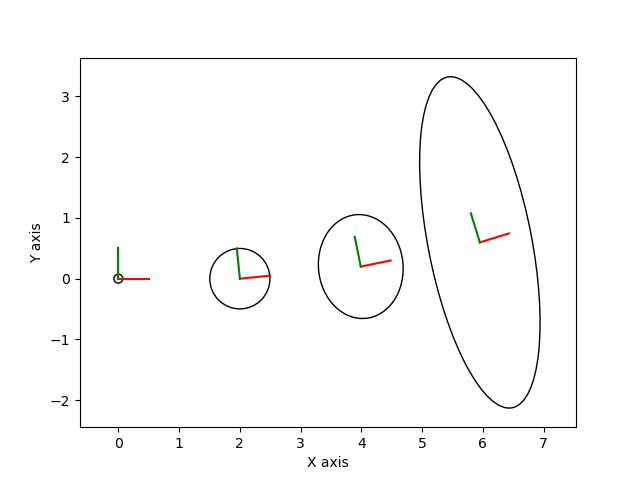

In [6]:
# Create noise models
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1]))
ODOMETRY_NOISE2 = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.5])) #test
# PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.1]))
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.03, 0.03, 0.01])) #test


# Create an empty nonlinear factor graph
graph = gtsam.NonlinearFactorGraph()

# Add a prior on the first pose, setting it to the origin
# A prior factor consists of a mean and a noise model (covariance matrix)
priorMean = gtsam.Pose2(0.0, 0.0, 0.0)  # prior at origin
graph.add(gtsam.PriorFactorPose2(1, priorMean, PRIOR_NOISE))

# Add odometry factors
odometry = gtsam.Pose2(2.0, 0.0, 0.1)
# For simplicity, we will use the same noise model for each odometry factor
# Create odometry (Between) factors between consecutive poses
graph.add(gtsam.BetweenFactorPose2(1, 2, odometry, ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPose2(2, 3, odometry, ODOMETRY_NOISE2))
graph.add(gtsam.BetweenFactorPose2(3, 4, odometry, ODOMETRY_NOISE2)) #test
# print("\nFactor Graph:\n{}".format(graph))

# Create the data structure to hold the initialEstimate estimate to the solution
# For illustrative purposes, these have been deliberately set to incorrect values
initial = gtsam.Values()
initial.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))
initial.insert(2, gtsam.Pose2(2.3, 0.1, -0.2))
initial.insert(3, gtsam.Pose2(4.1, 0.1, 0.1))
initial.insert(4, gtsam.Pose2(4.1, 0.1, 0.1))#test
# print("\nInitial Estimate:\n{}".format(initial))

#used for 2D
# optimize using Levenberg-Marquardt optimization
params = gtsam.LevenbergMarquardtParams() 
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)

result = optimizer.optimize()
# print("\nFinal Result:\n{}".format(result))

# 5. Calculate and print marginal covariances for all variables
marginals = gtsam.Marginals(graph, result)
# for i in range(1, 4):
#     print("X{} covariance:\n{}\n".format(i,
#                                          marginals.marginalCovariance(i)))

for i in range(1, 5):
    gtsam_plot.plot_pose2(0, result.atPose2(i), 0.5,
                          marginals.marginalCovariance(i))
plt.axis('equal')
plt.show()

In [ ]:
#test plotting 2D odometry estimates
# a = gtsam.Pose2(0.5, 0.0, 0.2)

print(result.atPose2(2))


# Pose3 SLAM Example

g2o is a file format for representing human-readable graphs for optimization problems
https://github.com/uoip/g2opy

In [28]:
g2oFile = "gtsampy/Data/pose3example.txt"
# g2oFile = gtsam.findExampleDataFile("pose3example.txt")
is3D = True
graph, initial  = gtsam.readG2o(g2oFile, is3D)
# print(initial)

priorModel = gtsam.noiseModel.Diagonal.Variances(
        np.array([1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4]))

firstKey = initial.keys()[0]
graph.add(gtsam.PriorFactorPose3(0, gtsam.Pose3(), priorModel))

initialization = gtsam.InitializePose3.initialize(graph)
# print(initialization)